In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
import pickle
with open('../DATA/super_res/super_res_array.pickle','rb') as f:
    img_array = pickle.load(f)


In [3]:
from sklearn.model_selection import train_test_split 

all_images = np.array(img_array)

#Split test and train data. all_images will be our output images
train_x, test_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [4]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 20):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
    return low_res_image

In [5]:
train_x_px = []
for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)
    
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
test_x_px = []
for i in range(test_x.shape[0]):
    temp = pixalate_image(test_x[i,:,:,:])
    test_x_px.append(temp)
    
test_x_px = np.array(test_x_px)     #Distorted images

In [6]:
train_x_px.shape

(10586, 160, 160, 3)

In [7]:
from AE_VGG.vggAE import VGGAE

In [8]:
vgg16AE = VGGAE(input_shape=(160,160,3), output_channels=3, vgg_decoder=True)
vgg16AE.summary()

Model: "VGGAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 VGG_encoder (Functional)    (None, 5, 5, 512)         14714688  
                                                                 
 VGG_decoder (Functional)    (None, 160, 160, 3)       17037059  
                                                                 
Total params: 31,751,747
Trainable params: 31,751,747
Non-trainable params: 0
_________________________________________________________________


In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
vgg16AE.compile(optimizer=optimizer, loss="mse")

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vgg16AE.fit(
    train_x_px,
    train_x,
    epochs=40,
    batch_size=80, 
    shuffle=True,
    validation_split=0.1, 
    callbacks=[early_stopping]
    )



Epoch 1/40
120/120 [==============================] - 117s 766ms/step - loss: 0.0816 - val_loss: 0.0804
Epoch 2/40
120/120 [==============================] - 85s 707ms/step - loss: 0.0711 - val_loss: 0.0423
Epoch 3/40
120/120 [==============================] - 85s 706ms/step - loss: 0.0345 - val_loss: 0.0252
Epoch 4/40
120/120 [==============================] - 85s 706ms/step - loss: 0.0216 - val_loss: 0.0191
Epoch 5/40
120/120 [==============================] - 85s 706ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 6/40
120/120 [==============================] - 85s 706ms/step - loss: 0.0166 - val_loss: 0.0154
Epoch 7/40
120/120 [==============================] - 85s 707ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 8/40
120/120 [==============================] - 85s 707ms/step - loss: 0.0133 - val_loss: 0.0145
Epoch 9/40
120/120 [==============================] - 85s 707ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 10/40
120/120 [==============================] - 85s 707ms/step - 

83/83 [==============================] - 21s 150ms/step


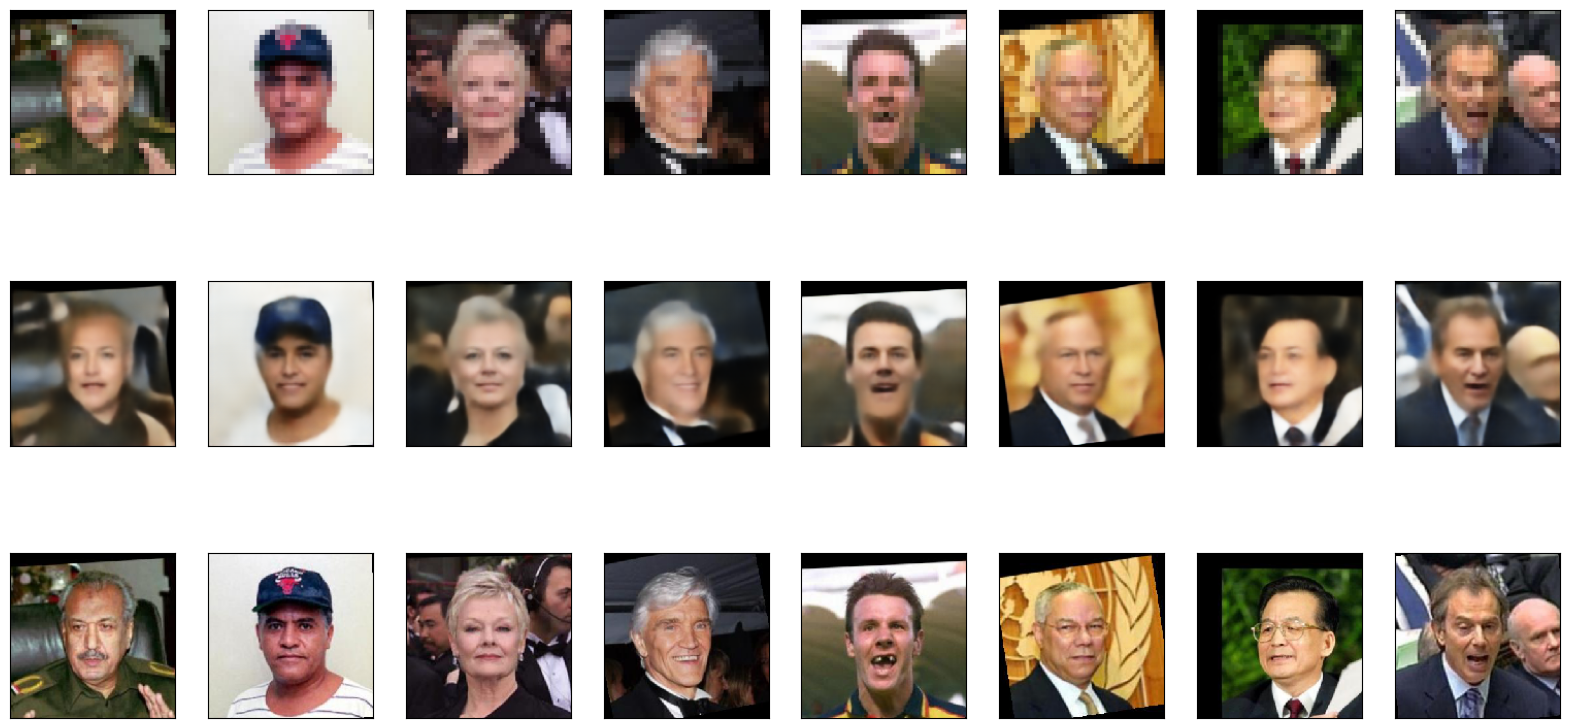

In [11]:
predictions = vgg16AE.predict(test_x_px)
n = 8
plt.figure(figsize= (20,10))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_x_px[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(test_x[i+3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
vgg16AE.save('final_models/vgg16AE_lr001.h5')

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lr(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

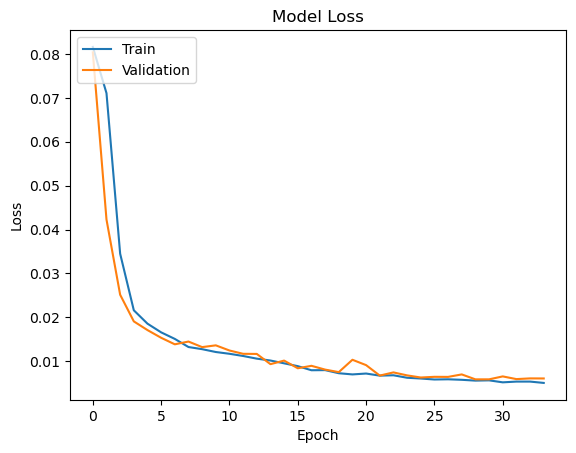

In [14]:
plot_lr(history)

In [14]:
print("hola")

hola


In [15]:
# ssim score
ssim = tf.image.ssim(test_x, predictions, max_val=1.0)
ssim = tf.reduce_mean(ssim)
print('SSIM Score:',ssim)

# psnr score
psnr = tf.image.psnr(test_x, predictions, max_val=1.0)
psnr = tf.reduce_mean(psnr)
print('PSNR Score:',psnr)

#mse score
mse = tf.keras.losses.mean_squared_error(test_x, predictions)
mse = tf.reduce_mean(mse)
print('MSE Score:',mse)

SSIM Score: tf.Tensor(0.67665625, shape=(), dtype=float32)
PSNR Score: tf.Tensor(22.728235, shape=(), dtype=float32)
MSE Score: tf.Tensor(0.005877414, shape=(), dtype=float32)
